In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
from models import BasicBlock, ResNet
from prediction_depth import ResNetForPredictionDepth, PredictionDepth
torch.autograd.set_detect_anomaly(True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ResNetForPredictionDepth(BasicBlock, [2, 2, 2, 2], temp=1.0, num_classes=len(classes))
metric = PredictionDepth(model, device=device, layers=9)


In [6]:
metric.train(trainloader, epochs=70)

Epoch 0



100%|██████████| 196/196 [00:33<00:00,  5.92it/s]


Epoch 1



100%|██████████| 196/196 [00:31<00:00,  6.24it/s]


Epoch 2



100%|██████████| 196/196 [00:31<00:00,  6.32it/s]


Epoch 3



100%|██████████| 196/196 [00:31<00:00,  6.24it/s]


Epoch 4



100%|██████████| 196/196 [00:31<00:00,  6.25it/s]


Epoch 5



100%|██████████| 196/196 [00:31<00:00,  6.32it/s]


Epoch 6



100%|██████████| 196/196 [00:30<00:00,  6.34it/s]


Epoch 7



100%|██████████| 196/196 [00:30<00:00,  6.34it/s]


Epoch 8



100%|██████████| 196/196 [00:31<00:00,  6.28it/s]


Epoch 9



100%|██████████| 196/196 [00:30<00:00,  6.35it/s]


Epoch 10



100%|██████████| 196/196 [00:31<00:00,  6.30it/s]


Epoch 11



100%|██████████| 196/196 [00:31<00:00,  6.28it/s]


Epoch 12



100%|██████████| 196/196 [00:31<00:00,  6.29it/s]


Epoch 13



100%|██████████| 196/196 [00:32<00:00,  6.11it/s]


Epoch 14



100%|██████████| 196/196 [00:31<00:00,  6.26it/s]


Epoch 15



100%|██████████| 196/196 [00:31<00:00,  6.26it/s]


Epoch 16



100%|██████████| 196/196 [00:31<00:00,  6.21it/s]


Epoch 17



100%|██████████| 196/196 [00:31<00:00,  6.29it/s]


Epoch 18



100%|██████████| 196/196 [00:31<00:00,  6.24it/s]


Epoch 19



100%|██████████| 196/196 [00:31<00:00,  6.23it/s]


Epoch 20



100%|██████████| 196/196 [00:31<00:00,  6.27it/s]


Epoch 21



100%|██████████| 196/196 [00:31<00:00,  6.23it/s]


Epoch 22



100%|██████████| 196/196 [00:31<00:00,  6.24it/s]


Epoch 23



100%|██████████| 196/196 [00:31<00:00,  6.21it/s]


Epoch 24



100%|██████████| 196/196 [00:32<00:00,  6.11it/s]


Epoch 25



100%|██████████| 196/196 [00:31<00:00,  6.15it/s]


Epoch 26



100%|██████████| 196/196 [00:30<00:00,  6.35it/s]


Epoch 27



100%|██████████| 196/196 [00:30<00:00,  6.33it/s]


Epoch 28



100%|██████████| 196/196 [00:31<00:00,  6.20it/s]


Epoch 29



100%|██████████| 196/196 [00:31<00:00,  6.20it/s]


Epoch 30



100%|██████████| 196/196 [00:30<00:00,  6.34it/s]


Epoch 31



100%|██████████| 196/196 [00:30<00:00,  6.36it/s]


Epoch 32



100%|██████████| 196/196 [00:31<00:00,  6.25it/s]


Epoch 33



100%|██████████| 196/196 [00:31<00:00,  6.23it/s]


Epoch 34



100%|██████████| 196/196 [00:30<00:00,  6.36it/s]


Epoch 35



100%|██████████| 196/196 [00:30<00:00,  6.33it/s]


Epoch 36



100%|██████████| 196/196 [00:31<00:00,  6.24it/s]


Epoch 37



100%|██████████| 196/196 [00:31<00:00,  6.31it/s]


Epoch 38



100%|██████████| 196/196 [00:30<00:00,  6.35it/s]


Epoch 39



100%|██████████| 196/196 [00:31<00:00,  6.20it/s]


Epoch 40



100%|██████████| 196/196 [00:31<00:00,  6.20it/s]


Epoch 41



100%|██████████| 196/196 [00:30<00:00,  6.36it/s]


Epoch 42



100%|██████████| 196/196 [00:31<00:00,  6.28it/s]


Epoch 43



100%|██████████| 196/196 [00:31<00:00,  6.28it/s]


Epoch 44



100%|██████████| 196/196 [00:31<00:00,  6.27it/s]


Epoch 45



100%|██████████| 196/196 [00:31<00:00,  6.28it/s]


Epoch 46



100%|██████████| 196/196 [00:31<00:00,  6.25it/s]


Epoch 47



100%|██████████| 196/196 [00:31<00:00,  6.17it/s]


Epoch 48



100%|██████████| 196/196 [00:31<00:00,  6.20it/s]


Epoch 49



100%|██████████| 196/196 [00:30<00:00,  6.33it/s]


Epoch 50



100%|██████████| 196/196 [00:30<00:00,  6.38it/s]


Epoch 51



100%|██████████| 196/196 [00:30<00:00,  6.49it/s]


Epoch 52



100%|██████████| 196/196 [00:30<00:00,  6.39it/s]


Epoch 53



100%|██████████| 196/196 [00:30<00:00,  6.38it/s]


Epoch 54



100%|██████████| 196/196 [00:30<00:00,  6.46it/s]


Epoch 55



100%|██████████| 196/196 [00:29<00:00,  6.54it/s]


Epoch 56



100%|██████████| 196/196 [00:31<00:00,  6.19it/s]


Epoch 57



100%|██████████| 196/196 [00:33<00:00,  5.90it/s]


Epoch 58



100%|██████████| 196/196 [00:32<00:00,  5.98it/s]


Epoch 59



100%|██████████| 196/196 [00:35<00:00,  5.51it/s]


Epoch 60



100%|██████████| 196/196 [00:34<00:00,  5.70it/s]


Epoch 61



100%|██████████| 196/196 [00:34<00:00,  5.72it/s]


Epoch 62



100%|██████████| 196/196 [00:34<00:00,  5.67it/s]


Epoch 63



100%|██████████| 196/196 [00:34<00:00,  5.69it/s]


Epoch 64



100%|██████████| 196/196 [00:35<00:00,  5.56it/s]


Epoch 65



100%|██████████| 196/196 [00:34<00:00,  5.61it/s]


Epoch 66



100%|██████████| 196/196 [00:34<00:00,  5.64it/s]


Epoch 67



100%|██████████| 196/196 [00:35<00:00,  5.59it/s]


Epoch 68



100%|██████████| 196/196 [00:35<00:00,  5.48it/s]


Epoch 69



100%|██████████| 196/196 [00:35<00:00,  5.52it/s]


In [7]:
model.get_num_layers()

10

In [8]:
from prediction_depth import ResNetForPredictionDepth, PredictionDepth

In [9]:
indices, metrics = metric.get_metric(testset)

print(indices.size(), metrics.size())

100%|██████████| 40/40 [00:02<00:00, 17.92it/s]
40it [03:26,  5.15s/it]
100%|██████████| 40/40 [00:01<00:00, 20.18it/s]
40it [03:26,  5.16s/it]
100%|██████████| 40/40 [00:02<00:00, 19.32it/s]
40it [03:26,  5.16s/it]
100%|██████████| 40/40 [00:01<00:00, 23.15it/s]
40it [01:43,  2.60s/it]
100%|██████████| 40/40 [00:02<00:00, 18.36it/s]
40it [01:44,  2.61s/it]
100%|██████████| 40/40 [00:02<00:00, 19.04it/s]
40it [00:53,  1.33s/it]
100%|██████████| 40/40 [00:02<00:00, 17.32it/s]
40it [00:53,  1.33s/it]
100%|██████████| 40/40 [00:02<00:00, 17.69it/s]
40it [00:27,  1.44it/s]
100%|██████████| 40/40 [00:02<00:00, 18.99it/s]
40it [00:27,  1.44it/s]
100%|██████████| 40/40 [00:02<00:00, 17.92it/s]
40it [00:02, 19.24it/s]

torch.Size([10000]) torch.Size([10000])


In [10]:
torch.bincount(metrics.int())

tensor([1266,  168,  133,  188,  125,  923, 1302, 3536, 1536,  126,  697],
       device='cuda:0')

In [11]:
torch.unique(metrics.int())

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0',
       dtype=torch.int32)

In [12]:
metrics.min(), metrics.max()

(tensor(0., device='cuda:0'), tensor(10., device='cuda:0'))

Images with the lowest VoG scores:


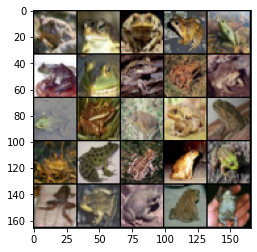

Images with the highest VoG scores:


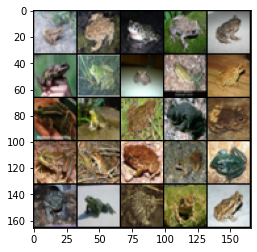

In [19]:
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def select_images_by_class(dataset, target_class):
    selected_images = []
    selected_labels = []

    for i in range(len(dataset)):
        image, label = dataset[i]
        if label == target_class:
            selected_images.append(image)
            selected_labels.append(label)

    return selected_images, selected_labels

def plot_extreme_vog_images(testset, indices, vog_scores, target_class, num_images=25):
    # Sort images by VoG scores
    sorted_indices = np.argsort(vog_scores)
    
    # Filter sorted_indices to only include indices of images that belong to the target class
    sorted_indices = [i for i in sorted_indices if testset[i][1] == target_class]
    
    # Select the top and bottom images
    lowest_vog_indices = sorted_indices[:num_images]
    highest_vog_indices = sorted_indices[-num_images:]
    
    # Create a dataset with the selected images
    lowest_vog_images = torch.stack([testset[i][0] for i in lowest_vog_indices])
    highest_vog_images = torch.stack([testset[i][0] for i in highest_vog_indices])

    # Plot the images with the lowest VoG scores
    print("Images with the lowest VoG scores:")
    imshow(vutils.make_grid(lowest_vog_images, nrow=num_images // 5, padding=1, normalize=True))

    # Plot the images with the highest VoG scores
    print("Images with the highest VoG scores:")
    imshow(vutils.make_grid(highest_vog_images, nrow=num_images // 5, padding=1, normalize=True))

# Visualize the 25 images with the lowest and highest VoG scores
plot_extreme_vog_images(trainset, indices.detach().cpu(), metrics.detach().cpu(), 6)
